In [1]:
import numpy as np
import pandas as pd

from os import listdir
import csv

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# this may be needed in case the lineplot not work, in case this error appear
# Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead

print('sns: ',sns.__version__, 'desired: 0.13.0')
print('plt: ',matplotlib.__version__, 'desired: 3.8.2')

# pip install seaborn==0.13.0
# or
# pip install seaborn --upgrade

sns:  0.13.0 desired: 0.13.0
plt:  3.8.2 desired: 3.8.2


In [5]:
# file with the csvs
file_path = '../Main/run2/'

# solvers names
solvers = ['cmaes', 'openaies']

In [6]:
# get the number of valid individuos from each iteration
def get_n_valids(file_path, file_name, use_P_B_as_valid=False):
    # load
    col_names = ['D', 'AEdAO', 'PdD', 'Z', 'P_B', 'n', 'fitness', 't075dD','tmin075dD', 'tal07R','cavLim', 'Vtip','Vtipmax', 'penalty', 'valid']
    df = pd.read_csv(file_path+'/'+file_name, header=None, skiprows=1, names=col_names)
    
    if use_P_B_as_valid:
        df['valid'] = (df['P_B'] > 0)
    else:
        # penalty and valid were not saved in this test, so need to be created
        df['penalty'] = df.apply(lambda x: max((x['tal07R'] - x['cavLim'])/x['cavLim'],0) + max((x['Vtip'] - x['Vtipmax'])/x['Vtipmax'],0) + max(((x['tmin075dD'] - x['t075dD'])/x['tmin075dD']), 0) , axis=1)
        df['valid'] = (df['penalty'] == 0)
    
    #
    iteration_counter_lines = df.loc[df['D'] == 'fitness at iteration'].index.to_numpy()
    iteration_counter_lines = np.insert(iteration_counter_lines, 0, -1) # # add the start -1 as the first element

    n_valids_list = []
    for k in range(len(iteration_counter_lines)-1):
        i = iteration_counter_lines[k] +1 # index from the dataframe (+1 to skip the fitness at iterat row)
        size = iteration_counter_lines[k+1] - i
        locs = [f for f in range(i, i+size)] # get the 12 elements from that iteration
        n_valids = df.iloc[locs]['valid']
        n_valids = sum(n_valids)
        n_valids_list.append(n_valids)
    return n_valids_list

In [7]:
# biggest percentage of difference on each individual parameter
def diff(x, y, ignore_last=False):
    max_diff = 0
    end = 1 if ignore_last else 0 # remove 1 from len if ignore_last
    for i in range(len(x) - end):
        cur_diff = abs(x[i] - y[i]) / max(x[i], y[i])
        max_diff = max(max_diff, cur_diff)
    return max_diff

# list of tuples, (differents, number of individuals) for each generation
def get_n_differents(file_path, file_name, only_valids=True, use_P_B_as_valid=False, threshold=0.004):
    # load
    col_names = ['D', 'AEdAO', 'PdD', 'Z', 'P_B', 'n', 'fitness', 't075dD','tmin075dD', 'tal07R','cavLim', 'Vtip','Vtipmax', 'penalty', 'valid']
    df = pd.read_csv(file_path+'/'+file_name, header=None, skiprows=1, names=col_names)
    
    if use_P_B_as_valid:
        df['valid'] = (df['P_B'] > 0)
    else:
        # penalty and valid were not saved in this test, so need to be created
        df['penalty'] = df.apply(lambda x: max((x['tal07R'] - x['cavLim'])/x['cavLim'],0) + max((x['Vtip'] - x['Vtipmax'])/x['Vtipmax'],0) + max(((x['tmin075dD'] - x['t075dD'])/x['tmin075dD']), 0) , axis=1)
        df['valid'] = (df['penalty'] == 0)
    
    #
    iteration_counter_lines = df.loc[df['D'] == 'fitness at iteration'].index.to_numpy()
    iteration_counter_lines = np.insert(iteration_counter_lines, 0, -1) # # add the start -1 as the first element

    n_diffs_list = []
    n_totals_list = []
    n_valids_list = []
    for k in range(len(iteration_counter_lines)-1):
        i = iteration_counter_lines[k] +1 # index from the dataframe (+1 to skip the fitness at iterat row)
        size = iteration_counter_lines[k+1] - i
        locs = [f for f in range(i, i+size)] # get the 12 elements from that iteration
        # df.iloc[locs] contains one iteration
        df_temp = df.iloc[locs][['D', 'AEdAO', 'PdD', 'Z']]
        df_temp = df_temp.astype({'D':float, 'AEdAO':float, 'PdD':float, 'Z':int})
        # valids
        valids_np = df.iloc[locs]['valid'].to_numpy()
        # for the elements comparing with each other
        df_temp_np = df_temp.to_numpy()
        diffs_np = np.ones(len(df_temp_np)) # got to be 1 so the last one is bigger than the threshold, since it's not being compared with the others
        #
        for i in range(len(df_temp_np)-1):
            elem_i = df_temp_np[i]
            min_diff = float('inf')
            for j in range(i+1, len(df_temp_np)):
                # only_valids is True: then compare elem_i to elem_j only if elem_j is valid
                # only_valids is False: just compare element
#                 if (not only_valids) or (only_valids and valids_np[j]):
                if True:
                    elem_j = df_temp_np[j]
                    curr_diff = diff(elem_i, elem_j, ignore_last=False)
                    curr_diff += abs(df_temp_np[i][-1] - df_temp_np[j][-1])
                    min_diff = min(min_diff, curr_diff)
            #
            diffs_np[i] = min_diff
        equals_np = [min_diff < threshold for min_diff in diffs_np]
        differents_np = np.logical_not(equals_np)
        # if only_valids then get only differents that are also valid
        if only_valids:
            differents_np = np.logical_and(differents_np, valids_np)
            
        n_diffs  = sum(differents_np)
        n_totals = len(differents_np)
        n_valids = sum(valids_np)
        n_diffs_list.append(n_diffs)
        n_totals_list.append(n_totals)
        n_valids_list.append(n_valids)
    return [n_diffs_list, n_totals_list, n_valids_list]


In [8]:
valids_by_vs = {}
diffes_by_vs = {}

# counter for number of runs (for each solver)
counter = {}

# for each run dir containg the solvers 
for run_dir_name in listdir(file_path):
    # read config
    csv_filename = file_path + run_dir_name + '/configs.csv'
    with open(csv_filename, 'r', newline='\n') as csvfile:
        csv_reader = csv.reader(csvfile)
        V_S    = next(csv_reader)[1]
        NPOP   = int(next(csv_reader)[1])
        MAX_IT = int(next(csv_reader)[1])
        SEED   = int(next(csv_reader)[1])
    # start dict if empty
    vs = V_S.replace('.','_')
    V_S = float(V_S)
    if vs not in valids_by_vs:
        valids_by_vs[vs] = {}
        diffes_by_vs[vs] = {}
    if solvers[0]+str(NPOP) not in solvers:
        for solver in solvers:
            solver += str(NPOP)
            valids_by_vs[vs][solver] = np.zeros(MAX_IT, dtype=int)
            diffes_by_vs[vs][solver] = np.zeros(MAX_IT, dtype=int)  
            counter[solver] = 0
    #
    print(file_path + '/' + run_dir_name)
    for solver in solvers:
        # read file
        temp_path = file_path + '/' + run_dir_name + '/' + solver
        solver += str(NPOP)
        for file_name in listdir(temp_path):
            n_diffes, _, n_valids = get_n_differents(temp_path, file_name, use_P_B_as_valid=(solver == 'original'), only_valids=True)
            # 60 has an iteration 0 together with 1 for some reason (0 is an extra iteration i guess)
            if solver == 'original':
                n_valids[0] = int((n_valids[0] / 2) + 0.6)
                n_diffes[0] = int((n_diffes[0] / 2) + 0.6)

            valids_by_vs[vs][solver] = np.add(valids_by_vs[vs][solver], n_valids)
            diffes_by_vs[vs][solver] = np.add(diffes_by_vs[vs][solver], n_diffes)
        # count by run (not by Z file) 
        counter[solver] += 1

# after passed the for each run dir
for solver in solvers:
    solver += str(NPOP)
    # get the mean
    valids_by_vs[vs][solver] = np.divide(valids_by_vs[vs][solver], counter[solver])
    diffes_by_vs[vs][solver] = np.divide(diffes_by_vs[vs][solver], counter[solver])


../Main/run2//main_2023_11_10_08_55
../Main/run2//main_2023_11_10_03_20
../Main/run2//main_2023_11_10_09_33
../Main/run2//main_2023_11_10_21_52
../Main/run2//main_2023_11_10_02_28
../Main/run2//main_2023_11_10_10_32
../Main/run2//main_2023_11_10_07_06
../Main/run2//main_2023_11_10_05_16
../Main/run2//main_2023_11_09_20_09
../Main/run2//main_2023_11_10_16_48
../Main/run2//main_2023_11_10_21_25
../Main/run2//main_2023_11_10_19_06
../Main/run2//main_2023_11_10_12_13
../Main/run2//main_2023_11_10_03_40
../Main/run2//main_2023_11_10_02_08
../Main/run2//main_2023_11_10_14_01
../Main/run2//main_2023_11_10_09_53
../Main/run2//main_2023_11_10_23_10
../Main/run2//main_2023_11_09_20_40
../Main/run2//main_2023_11_09_23_59
../Main/run2//main_2023_11_10_10_53
../Main/run2//main_2023_11_10_15_49
../Main/run2//main_2023_11_09_22_16
../Main/run2//main_2023_11_10_15_23
../Main/run2//main_2023_11_10_11_13
../Main/run2//main_2023_11_10_18_08
../Main/run2//main_2023_11_10_22_44
../Main/run2//main_2023_11_1

In [9]:
n_generations = 30

for vs in ['7_0', '7_5', '8_0', '8_5']:
    file_path = '../Main/run3/' + vs
    print('loading', vs)
    
    # solvers depending on the vs
    if vs in ['7_0', '7_5']:
        solvers = ['cmaes', 'openaies', 'original', 'original_old']
    else:
        solvers = ['cmaes', 'openaies', 'original']
    solvers += ['cmaes_old', 'openaies_old']
    
    # counter for number of runs (for each solver)
    counter = {}
    
    # init dir with 0
    for solver in solvers:
        if solver not in diffes_by_vs:
            diffes_by_vs[vs][solver] = np.zeros(n_generations, dtype=int)
            valids_by_vs[vs][solver] = np.zeros(n_generations, dtype=int)
            counter[solver] = 0
        
    # for each run dir containg the solvers 
    for run_dir_name in listdir(file_path):
        for solver in solvers:
            if solver == 'cmaes_old':
                temp_path = file_path + '/' + run_dir_name + '/' + 'cmaes'
            elif solver == 'openaies_old':
                temp_path = file_path + '/' + run_dir_name + '/' + 'openaies'
            else:
                # read file
                temp_path = file_path + '/' + run_dir_name + '/' + solver
            print(temp_path)
            for file_name in listdir(temp_path):
#                 --------------------------------
                n_diffs, _, n_valids= get_n_differents(temp_path, file_name, use_P_B_as_valid=(solver == 'original_old'), only_valids=True)
                # 60 has an iteration 0 together with 1 for some reason (0 is an extra iteration i guess)
                if (solver == 'original' or solver == 'original_old') and vs in ['7_0', '7_5']:
                    n_diffs[0]  = int((n_diffs[0] / 2) + 0.6)
                    n_valids[0] = int((n_valids[0] / 2) + 0.6)
                
                diffes_by_vs[vs][solver] = np.add(diffes_by_vs[vs][solver], n_diffs)
                valids_by_vs[vs][solver] = np.add(valids_by_vs[vs][solver], n_valids)
            # count by run (not by Z file) 
            counter[solver] += 1
                
    # after passed the for each run dir
    for solver in solvers:
        # get the mean
        valids_by_vs[vs][solver] = np.divide(valids_by_vs[vs][solver], counter[solver])
        diffes_by_vs[vs][solver] = np.divide(diffes_by_vs[vs][solver],  counter[solver])
        

loading 7_0
../Main/run3/7_0/main_2023_08_07_20_25/cmaes
../Main/run3/7_0/main_2023_08_07_20_25/openaies
../Main/run3/7_0/main_2023_08_07_20_25/original
../Main/run3/7_0/main_2023_08_07_20_25/original_old
../Main/run3/7_0/main_2023_08_07_20_25/cmaes
../Main/run3/7_0/main_2023_08_07_20_25/openaies
../Main/run3/7_0/main_2023_08_07_23_47/cmaes
../Main/run3/7_0/main_2023_08_07_23_47/openaies
../Main/run3/7_0/main_2023_08_07_23_47/original
../Main/run3/7_0/main_2023_08_07_23_47/original_old
../Main/run3/7_0/main_2023_08_07_23_47/cmaes
../Main/run3/7_0/main_2023_08_07_23_47/openaies
../Main/run3/7_0/main_2023_08_07_19_52/cmaes
../Main/run3/7_0/main_2023_08_07_19_52/openaies
../Main/run3/7_0/main_2023_08_07_19_52/original
../Main/run3/7_0/main_2023_08_07_19_52/original_old
../Main/run3/7_0/main_2023_08_07_19_52/cmaes
../Main/run3/7_0/main_2023_08_07_19_52/openaies
../Main/run3/7_0/main_2023_08_07_22_41/cmaes
../Main/run3/7_0/main_2023_08_07_22_41/openaies
../Main/run3/7_0/main_2023_08_07_22_4

../Main/run3/8_5/main_2023_08_08_13_15/cmaes
../Main/run3/8_5/main_2023_08_08_13_15/openaies
../Main/run3/8_5/main_2023_08_08_12_15/cmaes
../Main/run3/8_5/main_2023_08_08_12_15/openaies
../Main/run3/8_5/main_2023_08_08_12_15/original
../Main/run3/8_5/main_2023_08_08_12_15/cmaes
../Main/run3/8_5/main_2023_08_08_12_15/openaies
../Main/run3/8_5/main_2023_08_08_11_18/cmaes
../Main/run3/8_5/main_2023_08_08_11_18/openaies
../Main/run3/8_5/main_2023_08_08_11_18/original
../Main/run3/8_5/main_2023_08_08_11_18/cmaes
../Main/run3/8_5/main_2023_08_08_11_18/openaies
../Main/run3/8_5/main_2023_08_08_11_46/cmaes
../Main/run3/8_5/main_2023_08_08_11_46/openaies
../Main/run3/8_5/main_2023_08_08_11_46/original
../Main/run3/8_5/main_2023_08_08_11_46/cmaes
../Main/run3/8_5/main_2023_08_08_11_46/openaies
../Main/run3/8_5/main_2023_08_08_14_43/cmaes
../Main/run3/8_5/main_2023_08_08_14_43/openaies
../Main/run3/8_5/main_2023_08_08_14_43/original
../Main/run3/8_5/main_2023_08_08_14_43/cmaes
../Main/run3/8_5/ma

In [10]:
#
valids_by_vs['7_5']

{'cmaes5': array([ 0,  0,  0,  0,  0,  0,  6,  6, 14, 14,  9, 13, 10, 29, 24, 20, 19,
        22, 27, 26, 25, 27, 26, 23, 28, 24, 22, 22, 17, 22]),
 'openaies5': array([ 0,  0,  0,  0,  4, 10, 10, 14, 13, 10, 13, 17, 24, 22, 26, 27, 29,
        30, 26, 30, 30, 27, 30, 24, 25, 27, 27, 25, 28, 24]),
 'cmaes10': array([ 6, 11, 37, 36, 22, 46, 46, 46, 43, 56, 57, 57, 40, 35, 46, 47, 38,
        43, 40, 42, 35, 46, 38, 37, 52, 42, 42, 49, 43, 52]),
 'openaies10': array([ 6,  6, 42, 50, 54, 60, 60, 59, 55, 54, 60, 56, 46, 50, 53, 58, 58,
        49, 53, 54, 56, 58, 57, 56, 53, 57, 43, 49, 44, 35]),
 'cmaes': array([ 8.9, 19.1, 24.5, 32.6, 40. , 42.9, 44.7, 43. , 46.3, 51.1, 51.1,
        54.1, 50. , 52.8, 53.1, 55.9, 52. , 53.2, 50.4, 49.7, 55.3, 50.7,
        49.7, 53.8, 52.4, 56.4, 55.9, 53.8, 55.8, 51.9]),
 'openaies': array([10.1, 24.5, 40.4, 50.9, 53.9, 58.6, 60.4, 57.9, 57.4, 55. , 55.1,
        57.1, 55.7, 59.9, 63. , 64.8, 66.1, 65.6, 64.9, 61. , 58.6, 56.4,
        57.2, 56.7, 58.2,

In [11]:
solver_names = {'original':     'DE Modificado',
                'original_old': 'DE Base',
                'cmaes':        'CMA-ES Modificado', 
                'openaies':     'OpenAI-ES Modificado', 
                'cmaes_old':    'CMA-ES', 
                'openaies_old': 'OpenAI-ES'
               }

In [12]:
default_palette = sns.color_palette()

# Sample data in a DataFrame
df_by_vs = pd.DataFrame({'Gerações': [], 'Diferentes': [], 'Algoritmo': [], 'VS': []})

ger = [i for i in range(1, 31)]

for vs in ['7_0', '7_5', '8_0', '8_5']:
    solvers = [s for s in ['original', 'original_old', 'cmaes_old', 'cmaes', 'openaies_old',  'openaies'] if s in valids_by_vs[vs]]
    for solver in solvers:
        diffs  = diffes_by_vs[vs][solver]
        valids = valids_by_vs[vs][solver]
        for i in range(len(diffs)):
            dif = diffs[i]
            val = valids[i]
            new_row = pd.DataFrame({'Gerações':   [i+1],
                                    'Diferentes': [dif],
                                    'Validos':    [val],
                                    'Algoritmo':  [solver_names[solver]],
                                    'VS':         [float(vs.replace('_','.'))]
                                    })
            # Add the new row to the DataFrame
            df_by_vs = pd.concat([df_by_vs, new_row], ignore_index=True)


In [13]:
df_by_vs

,Gerações,Diferentes,Algoritmo,VS,Validos
0,1.0,3.6,DE Modificado,7.0,3.6
1,2.0,4.2,DE Modificado,7.0,4.2
2,3.0,4.1,DE Modificado,7.0,4.1
3,4.0,5.3,DE Modificado,7.0,5.3
4,5.0,6.0,DE Modificado,7.0,6.0
...,...,...,...,...,...
655,26.0,29.6,OpenAI-ES Modificado,8.5,32.7
656,27.0,28.4,OpenAI-ES Modificado,8.5,32.6
657,28.0,33.2,OpenAI-ES Modificado,8.5,34.3
658,29.0,36.2,OpenAI-ES Modificado,8.5,40.4


Graph

In [14]:
palette_ = sns.color_palette("tab10").as_hex()
# Dicionário de cores associadas aos algoritmos
cores_algoritmo = {'DE Base':               palette_[2], 
                   'DE Modificado':         palette_[8],
                   'CMA-ES':                palette_[0],
                   'CMA-ES Modificado':     palette_[4],
                   'OpenAI-ES':             palette_[1],
                   'OpenAI-ES Modificado':  palette_[5]
                   }

ordem = ['DE Base', 
        'DE Modificado',
        'CMA-ES',
        'CMA-ES Modificado',
        'OpenAI-ES',
        'OpenAI-ES Modificado']

In [37]:
def create_graph_sns(vs, save=True, have_legend=False):
    plt.figure(figsize=(8, 5))
    # Create the line plot with different line styles
    sns.set(style="whitegrid")
    
    
    df = df_by_vs.loc[df_by_vs['VS'] == vs]
    ax = sns.lineplot(data=df,
                         x='Gerações',
                         y='Diferentes',
                         linestyle='solid',
#                          ci=None,
                         errorbar=None,
                         hue='Algoritmo',
                         hue_order=ordem,
                         palette=cores_algoritmo
                     )

    
    # Set labels and title
    plt.xlabel('Gerações', size=15)
    plt.ylabel('Número de Configurações Diferentes', size=15)
    plt.title('Número de configurações válidas diferentes para VS='+str(vs), size=15)

    if have_legend:
        # Mova a legenda para fora da imagem
        ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5), fontsize=12)
    else:
        ax.get_legend().remove()  # Remove the legend

    plt.ylim(0, 60)
    plt.xlim(1, 30)
    
    if save:
        name_f = 'diffs_'+ str(vs).replace('.','_') + '.pdf'
        plt.savefig(name_f, bbox_inches='tight')
        print('saved')
        
    # Display the plot
    plt.show()

saved


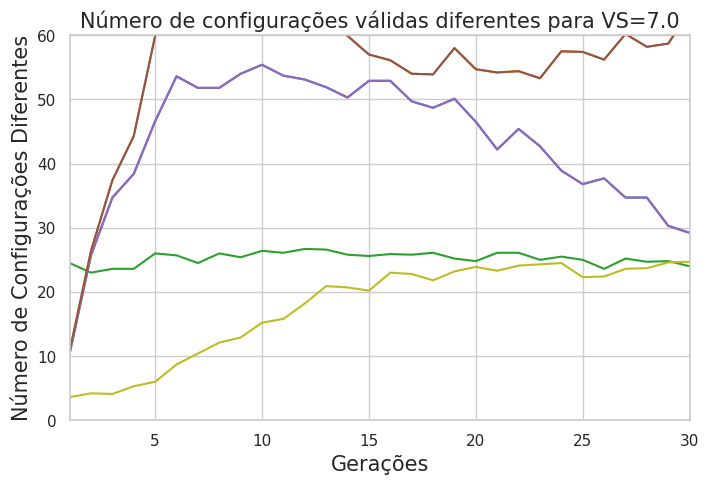

In [38]:
create_graph_sns(7.0)

saved


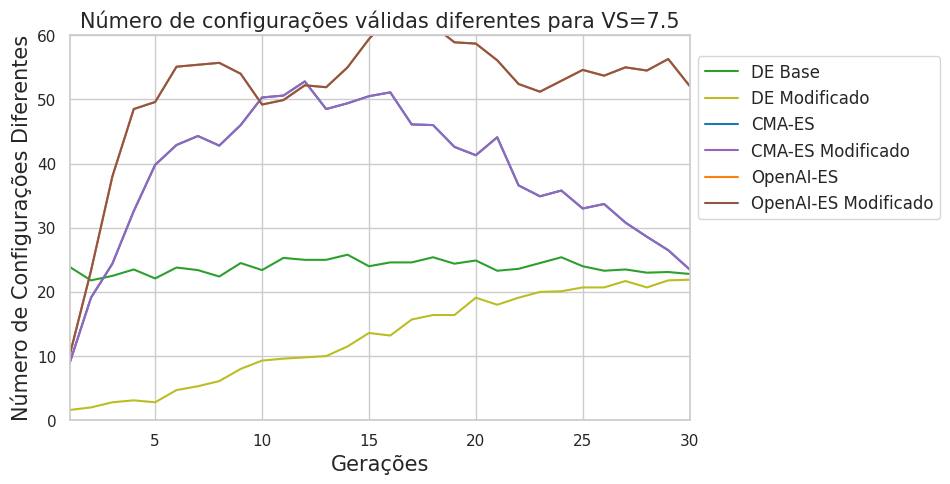

In [39]:
create_graph_sns(7.5, have_legend=True)

saved


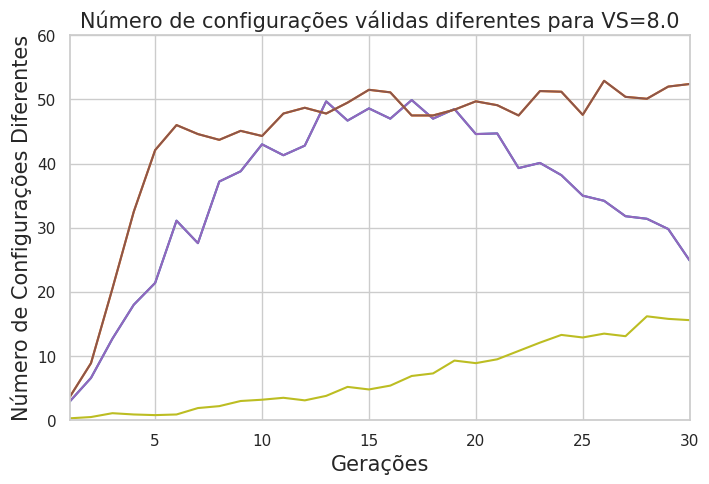

In [40]:
create_graph_sns(8.0)

saved


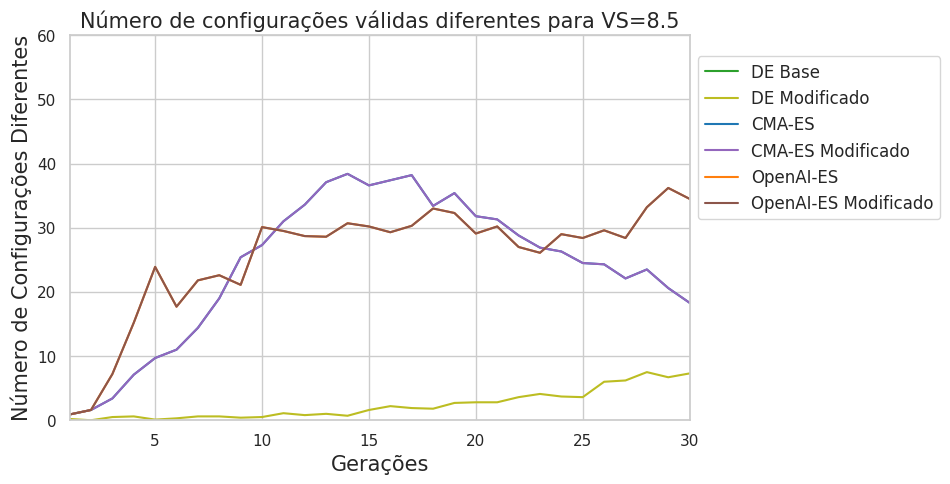

In [41]:
create_graph_sns(8.5, have_legend=True)

Valids ---  Differents ___

In [42]:
def create_graph_validos_sns(vs, save=True, have_legend=False):
    plt.figure(figsize=(8, 5))
    # Create the line plot with different line styles
    sns.set(style="whitegrid")
    
    ordem2 = ['CMA-ES Modificado', 'CMA-ES Modificado','OpenAI-ES Modificado', 'OpenAI-ES Modificado']

    cores_algoritmo2 = {
                       'Diferentes CMA-ES Modificado':     palette_[4],
                       'Válidos CMA-ES Modificado':     palette_[4],
                       'Diferentes OpenAI-ES Modificado':  palette_[5],
                       'Válidos OpenAI-ES Modificado':  palette_[5],
                        'CMA-ES': palette_[4],
                        'CMA-ES Modificado': palette_[4],
                        'OpenAI-ES': palette_[5],
                        'OpenAI-ES Modificado': palette_[5]
                       }


    df = df_by_vs.loc[df_by_vs['VS'] == vs]
    df = df[df['Algoritmo'] != 'DE Modificado']
    df = df[df['Algoritmo'] != 'DE Base']
    df = df[df['Algoritmo'] != 'CMA-ES']
    df = df[df['Algoritmo'] != 'OpenAI-ES']


    df_copy = df.copy()
    df['Estilo'] = 'Diferente'
    df_copy['Diferentes'], df_copy['Validos'] = df_copy['Validos'], df_copy['Diferentes']
    df_copy['Estilo'] = 'Válido'
    #
    # df['Algoritmo']      = 'Diferentes ' + df['Algoritmo'] 
    # df_copy['Algoritmo'] = 'Válidos '    + df_copy['Algoritmo'] 

    # Concatenate the original DataFrame with the copy
    result_df = pd.concat([df, df_copy], ignore_index=True)


    # Set the style based on the 'Algoritmo' column
    dashes={"CMA-ES": "--", "OpenAI-ES": "--", "OtherAlgorithm": "-"}

    # Create a line plot
    ax= sns.lineplot(data=result_df, 
                     x='Gerações', 
                     y='Diferentes', 
                     hue='Algoritmo', 
                     style='Estilo',
#                      ci=None,
                     errorbar=None,
                     hue_order=ordem2,
                     palette=cores_algoritmo2
                    )
    
    
#     # Set labels and title
    plt.xlabel('Gerações', size=15)
    plt.ylabel('Número de Configurações', size=15)
    plt.title('Número de configurações válidas para VS='+str(vs), size=15)

    if have_legend:
        # Mova a legenda para fora da imagem
        ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5), fontsize=12)
    else:
        ax.get_legend().remove()  # Remove the legend


    plt.ylim(0, 60)
    plt.xlim(1, 30)

    if save:
        name_f = 'valids_'+ str(vs).replace('.','_') + '.pdf'
        plt.savefig(name_f, bbox_inches='tight')
        print('saved')
        
    # Display the plot
    plt.show()

saved


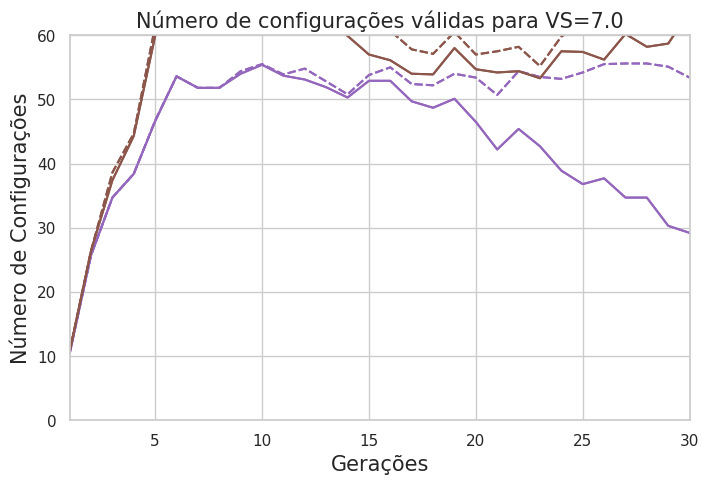

In [43]:
create_graph_validos_sns(7.0, have_legend=False)

saved


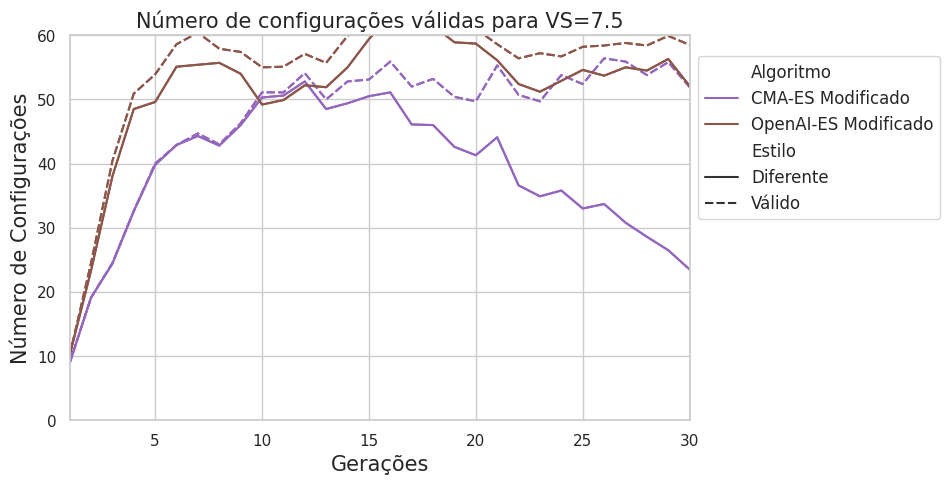

In [44]:
create_graph_validos_sns(7.5, have_legend=True)

saved


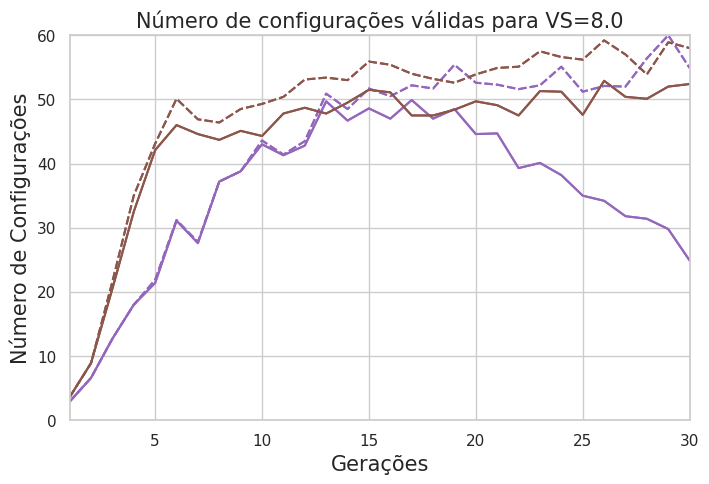

In [45]:
create_graph_validos_sns(8.0)

saved


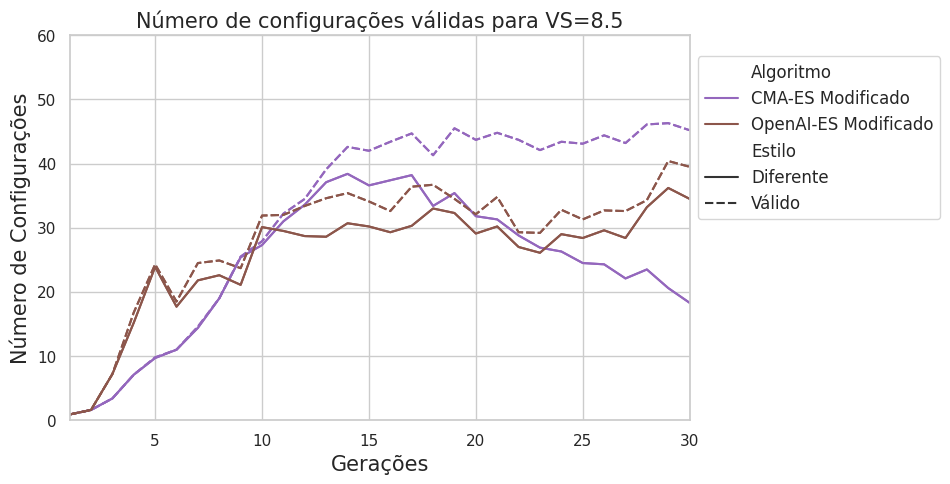

In [46]:
create_graph_validos_sns(8.5, have_legend=True)

## fitness por geracao

In [47]:
file_path = '../Main/run2/'
solvers = ['cmaes', 'openaies']

df_history = pd.DataFrame(data={'fitness': [], 'Gerações': [], 'Algoritmo': [], 'VS': [], 'Seed': []})


# for each run dir containg the solvers 
for run_dir_name in listdir(file_path):
    # read config
    csv_filename = file_path + run_dir_name + '/configs.csv'
    with open(csv_filename, 'r', newline='\n') as csvfile:
        csv_reader = csv.reader(csvfile)
        V_S    = next(csv_reader)[1]
        NPOP   = int(next(csv_reader)[1])
        MAX_IT = int(next(csv_reader)[1])
        SEED   = int(next(csv_reader)[1])
    vs = V_S.replace('.','_')
    V_S = float(V_S)
              
    # run dir
    run_dir = file_path + '/' + run_dir_name
    for file_name in listdir(run_dir):
        if 'best_results' in file_name:
            # read csv
            csv_filename = run_dir + '/' + file_name
            with open(csv_filename, 'r', newline='\n') as csvfile:
                csv_reader = csv.reader(csvfile)
                _ = next(csv_reader)
                _ = next(csv_reader)
                _ = next(csv_reader)
                history = next(csv_reader)
            #
            if 'cmaes' in file_name:
                solver_ = 'CMA-ES' + str(NPOP)
            elif 'openaies' in file_name:
                solver_ = 'OpenAI-ES' + str(NPOP)
            for i in range(len(history)):
                h = -float(history[i])
                nova_linha = pd.DataFrame({'fitness': [h], 'Gerações': [i+1], 'Algoritmo': [solver_], 'VS': [V_S], 'Seed': SEED})
                df_history = pd.concat([df_history, nova_linha], ignore_index=True)
        
df_history['Gerações'] = df_history['Gerações'].astype(int)
df_history['Seed']    = df_history['Seed'].astype(int)

df_history

,fitness,Gerações,Algoritmo,VS,Seed
0,225.297958,1,OpenAI-ES5,8.0,0
1,185.521085,2,OpenAI-ES5,8.0,0
2,174.279532,3,OpenAI-ES5,8.0,0
3,162.164728,4,OpenAI-ES5,8.0,0
4,137.934485,5,OpenAI-ES5,8.0,0
...,...,...,...,...,...
4675,135.581228,26,CMA-ES10,8.0,1
4676,135.576418,27,CMA-ES10,8.0,1
4677,135.574609,28,CMA-ES10,8.0,1
4678,135.574609,29,CMA-ES10,8.0,1


In [57]:
for vs in ['7_0', '7_5', '8_0', '8_5']:
    file_path = '../Main/run3/' + vs
    print('loading', vs)
    
    # solvers depending on the vs
    if vs in ['7_0', '7_5']:
        solvers = ['cmaes', 'openaies', 'original', 'original_old']
    else:
        solvers = ['cmaes', 'openaies', 'original']
    solvers += ['cmaes_old', 'openaies_old']
        
    # for each run dir containg the solvers 
    for run_dir_name in listdir(file_path):
        print(run_dir_name)
        # read config
        csv_filename = file_path +'/'+ run_dir_name + '/configs.csv'
        with open(csv_filename, 'r', newline='\n') as csvfile:
            csv_reader = csv.reader(csvfile)
            V_S    = next(csv_reader)[1]
            NPOP   = int(next(csv_reader)[1])
            MAX_IT = int(next(csv_reader)[1])
            SEED   = int(next(csv_reader)[1])
        V_S = float(V_S)
        
        # 
        for solver in solvers:
            if solver == 'cmaes_old':
                temp_path = file_path + '/' + run_dir_name + '/' + 'cmaes'
            elif solver == 'openaies_old':
                temp_path = file_path + '/' + run_dir_name + '/' + 'openaies'
            else:
                temp_path = file_path + '/' + run_dir_name + '/' + solver
            for csv_name in listdir(temp_path):
#               --------------------------------
                # load
                col_names = ['D', 'AEdAO', 'PdD', 'Z', 'P_B', 'n', 'fitness', 't075dD','tmin075dD', 'tal07R','cavLim', 'Vtip','Vtipmax', 'penalty', 'valid']
                df = pd.read_csv(temp_path+'/'+csv_name, header=None, skiprows=1, names=col_names)
                
                use_P_B_as_valid=(solver == 'original_old')
                
                if use_P_B_as_valid:
                    df['valid'] = (df['P_B'] > 0)
                else:
                    # penalty and valid were not saved in this test, so need to be created
                    df['penalty'] = df.apply(lambda x: max((x['tal07R'] - x['cavLim'])/x['cavLim'],0) + max((x['Vtip'] - x['Vtipmax'])/x['Vtipmax'],0) + max(((x['tmin075dD'] - x['t075dD'])/x['tmin075dD']), 0) , axis=1)
                    df['valid'] = (df['penalty'] == 0)
                #
                history = []
                #
                iteration_counter_lines = df.loc[df['D'] == 'fitness at iteration'].index.to_numpy()
                for k in range(len(iteration_counter_lines)):
                    i = iteration_counter_lines[k] +1 # index from the dataframe (+1 to skip the fitness at iterat row)
                    df_temp = df.iloc[i-1][['AEdAO', 'fitness']]
                    ger, fit = df_temp.to_numpy()
                    ger = int(ger)
                    history.append(fit)
                #
                for i in range(len(history)):
                    h = abs(float(history[i]))
                    nova_linha = pd.DataFrame({'fitness': [h], 'Gerações': [i+1], 'Algoritmo': [solver], 'VS': [V_S], 'Seed': SEED})
                    df_history = pd.concat([df_history, nova_linha], ignore_index=True)
        
df_history['Gerações'] = df_history['Gerações'].astype(int)
df_history['Seed']    = df_history['Seed'].astype(int)

df_history

loading 7_0
main_2023_08_07_20_25
main_2023_08_07_23_47
main_2023_08_07_19_52
main_2023_08_07_22_41
main_2023_08_07_18_43
main_2023_08_07_21_33
main_2023_08_07_19_18
main_2023_08_07_23_14
main_2023_08_07_22_07
main_2023_08_07_21_00
loading 7_5
main_2023_08_08_02_53
main_2023_08_08_03_51
main_2023_08_08_04_23
main_2023_08_08_01_51
main_2023_08_08_02_21
main_2023_08_08_03_21
main_2023_08_08_00_50
main_2023_08_08_01_20
main_2023_08_08_00_22
main_2023_08_08_04_52
loading 8_0
main_2023_08_08_07_56
main_2023_08_08_08_25
main_2023_08_08_06_56
main_2023_08_08_08_53
main_2023_08_08_09_23
main_2023_08_08_05_55
main_2023_08_08_06_25
main_2023_08_08_05_25
main_2023_08_08_09_52
main_2023_08_08_07_27
loading 8_5
main_2023_08_08_13_15
main_2023_08_08_12_15
main_2023_08_08_11_18
main_2023_08_08_11_46
main_2023_08_08_14_43
main_2023_08_08_12_44
main_2023_08_08_13_44
main_2023_08_08_14_14
main_2023_08_08_10_21
main_2023_08_08_10_50


,fitness,Gerações,Algoritmo,VS,Seed
0,225.297958,1,OpenAI-ES5,8.0,0
1,185.521085,2,OpenAI-ES5,8.0,0
2,174.279532,3,OpenAI-ES5,8.0,0
3,162.164728,4,OpenAI-ES5,8.0,0
4,137.934485,5,OpenAI-ES5,8.0,0
...,...,...,...,...,...
65875,175.754476,26,openaies_old,8.5,1
65876,175.754476,27,openaies_old,8.5,1
65877,175.754476,28,openaies_old,8.5,1
65878,175.754476,29,openaies_old,8.5,1


In [58]:
df_history.tail(35)

,fitness,Gerações,Algoritmo,VS,Seed
65845,171.921995,26,openaies_old,8.5,1
65846,171.921995,27,openaies_old,8.5,1
65847,171.921995,28,openaies_old,8.5,1
65848,171.921995,29,openaies_old,8.5,1
65849,171.921995,30,openaies_old,8.5,1
65850,354.988127,1,openaies_old,8.5,1
65851,240.001708,2,openaies_old,8.5,1
65852,193.990437,3,openaies_old,8.5,1
65853,175.754476,4,openaies_old,8.5,1
65854,175.754476,5,openaies_old,8.5,1


In [59]:
melhores_seeds = df_history[df_history['Gerações'] == 30].groupby(['VS', 'Algoritmo'])['fitness'].idxmin()
df_melhores_seeds = df_history.loc[melhores_seeds]
df_melhores_seeds

,fitness,Gerações,Algoritmo,VS,Seed
3239,81.405091,30,CMA-ES10,7.0,0
4019,81.407038,30,CMA-ES5,7.0,7
1349,81.436367,30,OpenAI-ES10,7.0,5
3719,81.429548,30,OpenAI-ES5,7.0,8
5549,81.405644,30,cmaes,7.0,9
5969,81.405644,30,cmaes_old,7.0,9
11189,81.421975,30,openaies,7.0,6
11609,81.421975,30,openaies_old,7.0,6
6629,81.492075,30,original,7.0,2
11339,81.470086,30,original_old,7.0,6


In [60]:
#  Descartar linhas com Algoritmo 
df_melhores_seeds = df_melhores_seeds[~df_melhores_seeds['Algoritmo'].isin(['cmaes', 'cmaes_old', 'openaies', 'openaies_old'])]
df_melhores_seeds

,fitness,Gerações,Algoritmo,VS,Seed
3239,81.405091,30,CMA-ES10,7.0,0
4019,81.407038,30,CMA-ES5,7.0,7
1349,81.436367,30,OpenAI-ES10,7.0,5
3719,81.429548,30,OpenAI-ES5,7.0,8
6629,81.492075,30,original,7.0,2
11339,81.470086,30,original_old,7.0,6
4619,106.194340,30,CMA-ES10,7.5,1
269,106.196122,30,CMA-ES5,7.5,5
1619,106.232818,30,OpenAI-ES10,7.5,3
4469,106.639985,30,OpenAI-ES5,7.5,3


In [61]:
df_melhores_seeds.loc[df_melhores_seeds['VS'] == 7.0]

,fitness,Gerações,Algoritmo,VS,Seed
3239,81.405091,30,CMA-ES10,7.0,0
4019,81.407038,30,CMA-ES5,7.0,7
1349,81.436367,30,OpenAI-ES10,7.0,5
3719,81.429548,30,OpenAI-ES5,7.0,8
6629,81.492075,30,original,7.0,2
11339,81.470086,30,original_old,7.0,6


In [62]:
df_temp = pd.DataFrame(data={}, columns=df_melhores_seeds.columns)

for i in range(len(df_melhores_seeds)):
    for k in range(31):
        r = df_melhores_seeds.iloc[i].copy()
        r['Gerações'] = k
        df_temp.loc[i*30+k] = r

df_new = pd.merge(df_history, df_temp, how='left', indicator=True)
df_new

,fitness,Gerações,Algoritmo,VS,Seed,_merge
0,225.297958,1,OpenAI-ES5,8.0,0,left_only
1,185.521085,2,OpenAI-ES5,8.0,0,left_only
2,174.279532,3,OpenAI-ES5,8.0,0,left_only
3,162.164728,4,OpenAI-ES5,8.0,0,left_only
4,137.934485,5,OpenAI-ES5,8.0,0,left_only
...,...,...,...,...,...,...
65875,175.754476,26,openaies_old,8.5,1,left_only
65876,175.754476,27,openaies_old,8.5,1,left_only
65877,175.754476,28,openaies_old,8.5,1,left_only
65878,175.754476,29,openaies_old,8.5,1,left_only


In [63]:
df_new[(df_new['VS'] == 8.0) & (df_new['Algoritmo'] == 'original')]

,fitness,Gerações,Algoritmo,VS,Seed,_merge
20640,197.230318,1,original,8.0,5,left_only
20641,197.230318,2,original,8.0,5,left_only
20642,197.230318,3,original,8.0,5,left_only
20643,197.230318,4,original,8.0,5,left_only
20644,197.230318,5,original,8.0,5,left_only
...,...,...,...,...,...,...
58015,138.93648,26,original,8.0,4,left_only
58016,138.93648,27,original,8.0,4,left_only
58017,138.93648,28,original,8.0,4,left_only
58018,138.93648,29,original,8.0,4,left_only


In [64]:
df_new = df_new.loc[df_new['Gerações'] <= 29]
df_new

,fitness,Gerações,Algoritmo,VS,Seed,_merge
0,225.297958,1,OpenAI-ES5,8.0,0,left_only
1,185.521085,2,OpenAI-ES5,8.0,0,left_only
2,174.279532,3,OpenAI-ES5,8.0,0,left_only
3,162.164728,4,OpenAI-ES5,8.0,0,left_only
4,137.934485,5,OpenAI-ES5,8.0,0,left_only
...,...,...,...,...,...,...
65874,175.754476,25,openaies_old,8.5,1,left_only
65875,175.754476,26,openaies_old,8.5,1,left_only
65876,175.754476,27,openaies_old,8.5,1,left_only
65877,175.754476,28,openaies_old,8.5,1,left_only


In [73]:
pd.options.mode.chained_assignment = None

df_new.drop(df_new[df_new['Algoritmo'] == 'cmaes_old'].index, inplace=True)
df_new.drop(df_new[df_new['Algoritmo'] == 'openaies_old'].index, inplace=True)


In [74]:
pd.unique(df_new['Algoritmo'])

array(['OpenAI-ES5', 'CMA-ES5', 'CMA-ES10', 'OpenAI-ES10', 'cmaes',
       'openaies', 'original', 'original_old'], dtype=object)

In [75]:
mapping_dict ={'original':     'DE Modificado',
                'original_old': 'DE Base',
                'CMA-ES10':      'CMA-ES Modificado', 
                'OpenAI-ES10':   'OpenAI-ES Modificado', 
                'CMA-ES5':    'CMA-ES', 
                'OpenAI-ES5': 'OpenAI-ES'
               }

In [76]:
df_new['Algoritmo'] = df_new['Algoritmo'].map(mapping_dict)
df_new

,fitness,Gerações,Algoritmo,VS,Seed,_merge
0,225.297958,1,OpenAI-ES,8.0,0,left_only
1,185.521085,2,OpenAI-ES,8.0,0,left_only
2,174.279532,3,OpenAI-ES,8.0,0,left_only
3,162.164728,4,OpenAI-ES,8.0,0,left_only
4,137.934485,5,OpenAI-ES,8.0,0,left_only
...,...,...,...,...,...,...
65514,179.599564,25,DE Modificado,8.5,1,left_only
65515,179.599564,26,DE Modificado,8.5,1,left_only
65516,179.599564,27,DE Modificado,8.5,1,left_only
65517,176.223584,28,DE Modificado,8.5,1,left_only


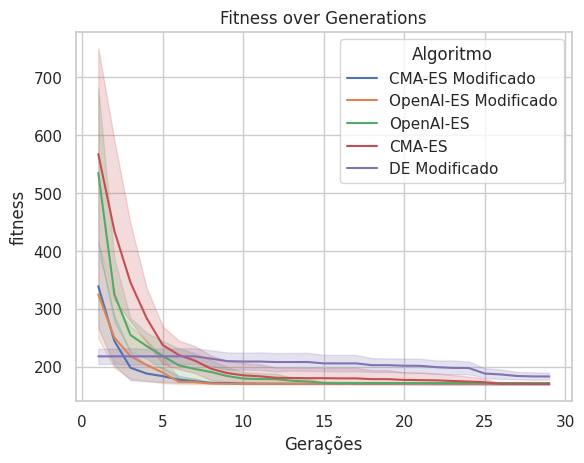

In [78]:
df = df_new.loc[df_new['VS'] == 8.5]
sns.lineplot(data=df, x='Gerações', y='fitness', hue='Algoritmo', markers=True)
plt.xlabel('Gerações')
plt.ylabel('fitness')
plt.title('Fitness over Generations')
plt.legend(title='Algoritmo')
plt.grid(True)
plt.show()


In [85]:
def create_graph_geracao_sns(vs, save=True):
    plt.figure(figsize=(6, 4))
    # Create the line plot with different line styles
    sns.set(style="whitegrid")
    
    df = df_new.loc[df_new['VS'] == vs]
    sns.lineplot(data=df,
                         x='Gerações', 
                         y='fitness', 
                         hue='Algoritmo', 
#                          ci=None,
                         errorbar=None,
                         markers=True)
    
    # Set labels and title
    plt.xlabel('Gerações', size=15)
    plt.ylabel('Fitness', size=15)
    plt.title('Melhor resultado por Geração para VS = '+str(vs), size=15)

    # Mova a legenda para fora da imagem
#     legend(loc='lower left', bbox_to_anchor=(1, 0.5), fontsize=12)

#     plt.ylim(80, 140)
    
    if save:
        name_f = 'fit_'+ str(vs).replace('.','_') + '.pdf'
        plt.savefig(name_f, bbox_inches='tight')
        print('saved')
        
    # Display the plot
    plt.show()

saved


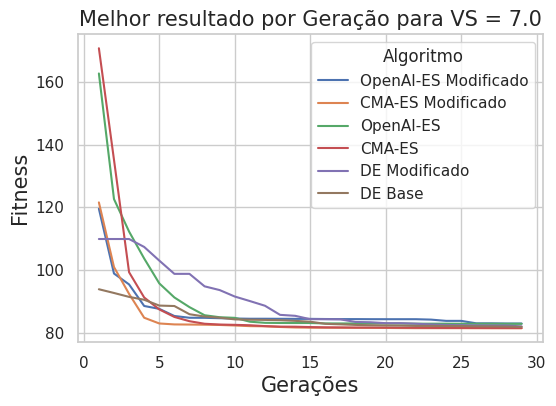

In [86]:
create_graph_geracao_sns(7.0)

saved


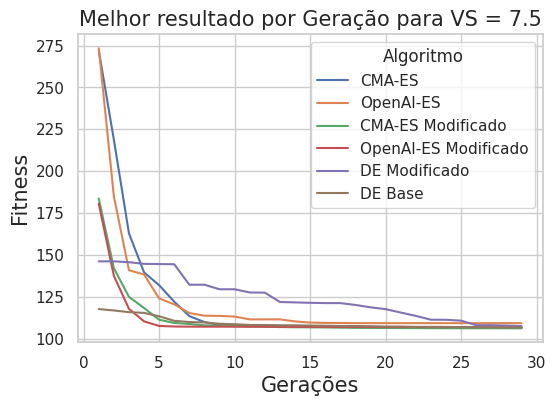

In [87]:
create_graph_geracao_sns(7.5)

saved


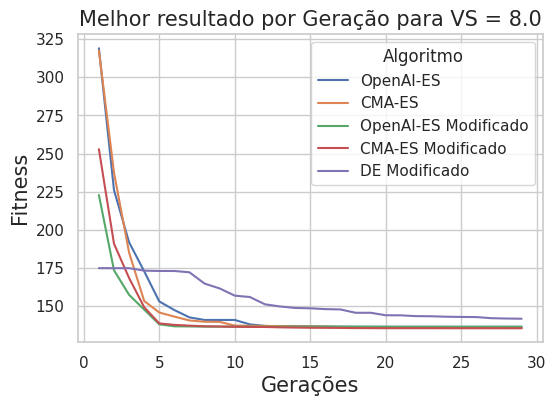

In [88]:
create_graph_geracao_sns(8.0)

saved


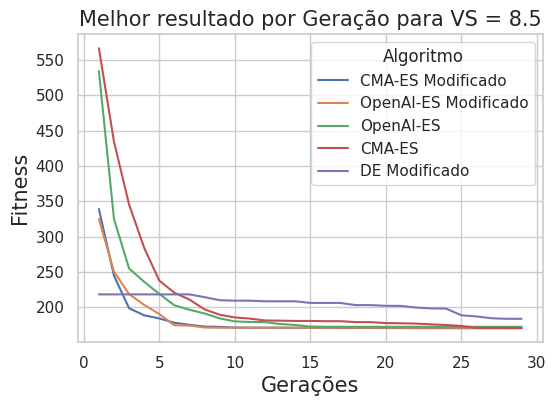

In [89]:
create_graph_geracao_sns(8.5)